# Spatial slices integration for heterogeneous samples
This tutorial demonstrates MISTIC’s ability to integrate heterogeneous spatial slices with distinct biological states.
The slices are derived from a mouse intraventricular hemorrhage (IVH) model, including three experimental groups: a no-surgery control group, a sham operation group (needle-puncture without blood injection), and an IVH model group (needle-puncture with blood injection). These heterogeneous slices exhibit inherent biological differences in cell composition and microenvironmental states while potentially containing technical batch effects. The processed data can be downloaded from https://drive.google.com/drive/folders/1Rsa7dLiUKyZWu05n0hsKuBlMvlaTWf3P?usp=drive_link.

## Loading and Processing

       MISTIC Pipeline Started

[Step 1/5] Loading and Preprocessing Data...
Found 3 files. Loading...
Loaded: GSM6604483
Loaded: GSM6604496
Loaded: GSM6604498
Number of common genes: 2740

[Step 2/5] Running BANKSY and Preparing Matrices...
Created output directory: ./output/banksy_processed
Starting BANKSY computation. Results will be saved to ./output/banksy_processed...

Median distance to closest cell = 366.0

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----


Median distance to closest cell = 366.0000

---- Ran generate_spatial_distance_graph in 0.01 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.10 s ----

---- Ran generate_spatial_distance_graph in 0.02 s ----

---- Ran theta_from_spatial_graph in 0.03 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.15 s ----

----- Plotting theta Graph -----
Runtime Dec-22-2025-10-25

2740 genes to be analysed:
Gene List:
Index(['1110008P

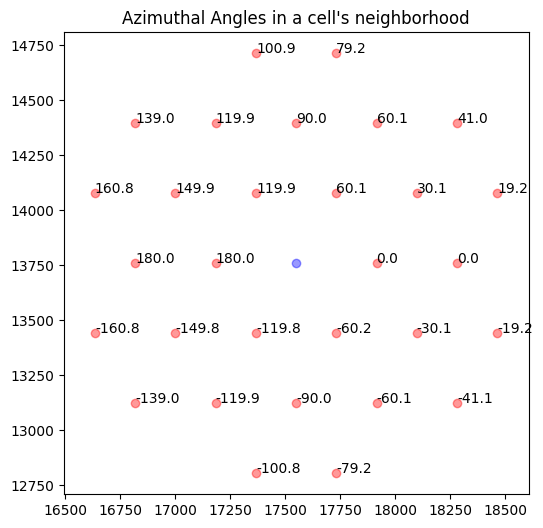

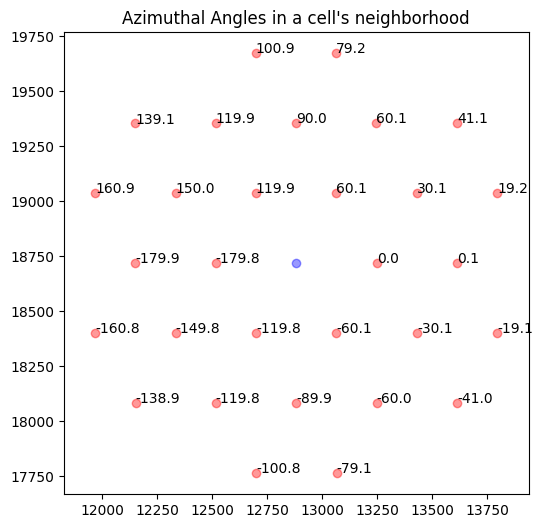

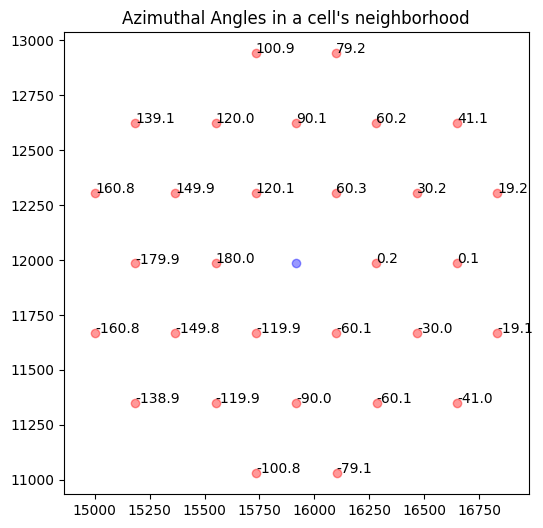

In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import MISTIC
INPUT_DIR = os.path.join('data', 'IVH')
OUTPUT_BANKSY_DIR = "./output/banksy_processed"

OUTPUT_FILE = os.path.join('output', 'mistic_result.h5ad')
# Preprocessing
N_TOP_GENES = 5000
# Graph Construction Parameters
SPATIAL_NEIGHBORS = 6  # k for spatial graph
SPATIAL_RADIUS = 150.0  # Radius for spatial graph
# Model Training Parameters
IS_HETEROGENEOUS = True  # Use GCN for output layer if True & dense MNN
NUM_EPOCHS = 500
CONTRASTIVE_WEIGHT = 0.2  # Coefficient for contrastive loss
LEARNING_RATE = 0.001
SEED = 42
print("==========================================")
print("       MISTIC Pipeline Started")
print("==========================================")
# ==========================================
# 2. Load and Preprocess
# ==========================================
print("\n[Step 1/5] Loading and Preprocessing Data...")
# Load .h5ad files and perform normalization
raw_adatas, filenames = MISTIC.load_and_preprocess(INPUT_DIR,n_top_genes=N_TOP_GENES)
# Align genes across all slices (intersection)
aligned_adatas = MISTIC.align_common_genes(raw_adatas)

# ==========================================
# 3. Generate BANKSY Features
# ==========================================
print("\n[Step 2/5] Running BANKSY and Preparing Matrices...")

# Compute Banksy matrices and concatenate original data
# Note: raw_adatas memory is cleared inside this function
adata_concat = MISTIC.get_banksy_results(aligned_adatas,filenames,output_dir = OUTPUT_BANKSY_DIR )

## Constructing Multi-View Graphs

In [3]:
print("\n[Step 3/5] Constructing Multi-View Graphs...")
X_adata, X_expr, X_gra, adj_concat, spatial_adj_concat, avg_mnn = MISTIC.construct_graph(banksy_dir=OUTPUT_BANKSY_DIR)


[Step 3/5] Constructing Multi-View Graphs...
Loading files from ./output/banksy_processed...
Processing GSM6604483_banksy.h5ad...
  --> Average degree: 32.3132
Processing GSM6604496_banksy.h5ad...
  --> Average degree: 32.6281
Processing GSM6604498_banksy.h5ad...
  --> Average degree: 32.5623
Concatenating data...
Constructing block diagonal matrices...
Computing Cross-Slice MNN...
MNN Average Degree: 12.0861
Cleaning up intermediate directory: ./output/banksy_processed
Cleanup successful.


## Running MISTIC AutoEncoder

In [4]:
print("\n[Step 4/5] Running MISTIC AutoEncoder...")

# Run the training loop
adata_result, model = MISTIC.run_training(
    adata_concat=adata_concat,
    X_adata=X_adata,
    X_expr=X_expr,
    X_gra=X_gra,
    adj_concat=adj_concat,
    spatial_adj_concat=spatial_adj_concat,
    mnn_avg_degree=avg_mnn,
    # Parameters
    is_heterogeneous=IS_HETEROGENEOUS,
    num_epochs=NUM_EPOCHS,
    contrastive_weight=CONTRASTIVE_WEIGHT,
    lr=LEARNING_RATE,
    seed=SEED
)

    # ==========================================
    # 6. Save Results
    # ==========================================
print(f"\n[Step 5/5] Saving results to {OUTPUT_FILE}...")

adata_result.write_h5ad(OUTPUT_FILE)


[Step 4/5] Running MISTIC AutoEncoder...
Running training on: cuda
Hyperparameters -> Heterogeneous: True, Epochs: 500, Contrastive Weight: 0.2
Preparing tensors and graphs...
Generating contrastive learning pairs...
Initializing AutoEncoder (Heterogeneous=True, MNN_Avg_Deg=12.09)...
Starting training for 500 epochs...


Training MISTIC: 100%|██████████| 500/500 [00:54<00:00,  9.12epoch/s, Con=0.2863, Rec=0.8256, Total_Loss=0.8828]


Training finished. Extracting embeddings...
Embedding saved to adata_concat.obsm['MISTIC']

[Step 5/5] Saving results to output/mistic_result.h5ad...


## Visualization

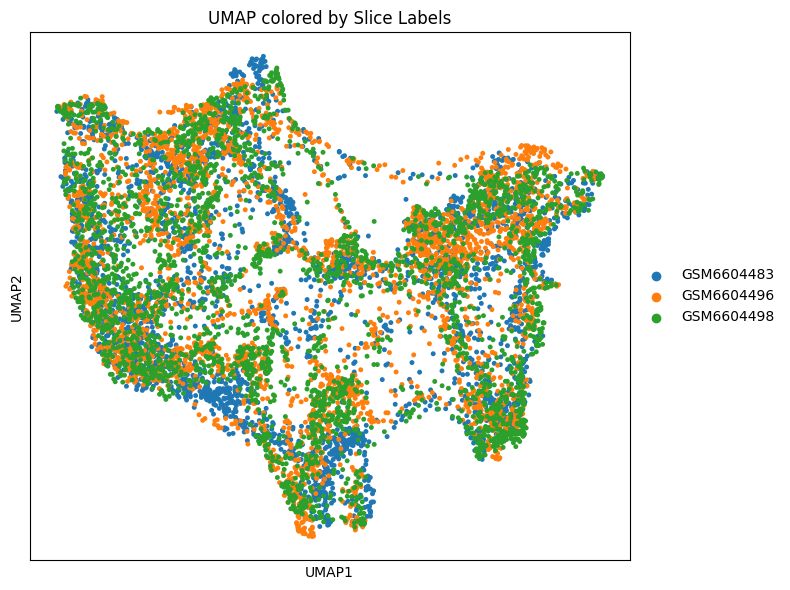

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
sc.pp.neighbors(adata_result, use_rep='MISTIC', n_neighbors=15)
sc.tl.umap(adata_result,random_state=42)

def plot_umap(adata_result, color_by, title=None, save_path=None):

    fig, ax = plt.subplots(figsize=(8, 6))

    sc.pl.umap(
        adata_result,
        color=color_by,
        show=False,
        title=title,
        frameon=True,
        ax=ax,
        size=50,
        legend_loc='right margin',
        legend_fontsize=10,
        legend_fontoutline=2
    )


    plt.tight_layout()

    if save_path:

        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:

        plt.show()

# slice_labels UMAP
plot_umap(adata_result, color_by=['slice_labels'], title='UMAP colored by Slice Labels')

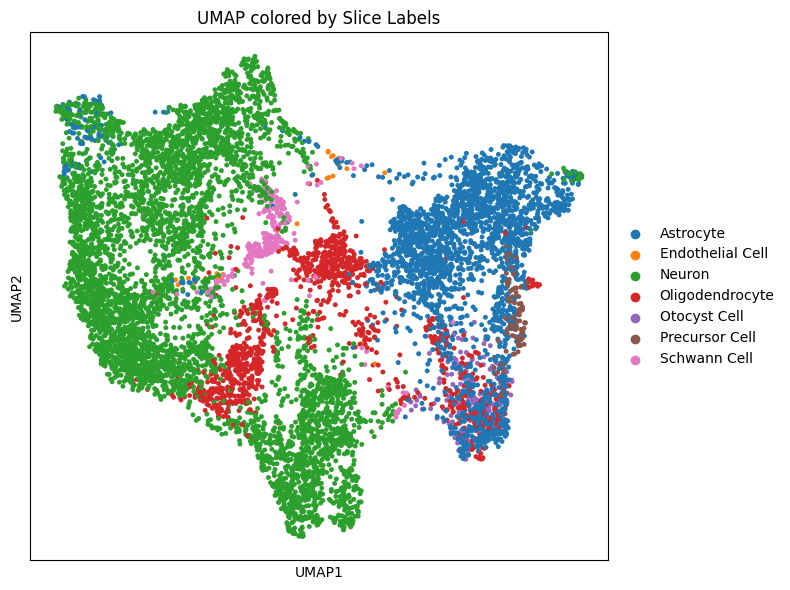

In [6]:
plot_umap(adata_result, color_by=['cell_type'], title='UMAP colored by Slice Labels')